In [2]:
import gym
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
## 策略网络
## 输入状态，输出选择每个动作的概率
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
    def forward(self,x):
        return self.fc2(self.fc1(x))

In [20]:
class Reinforce():
    def __init__(self,state_dim,hidden_dim,action_dim,gamma,lr,device):
        self.policy_net=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.optimizer=optim.Adam(self.policy_net.parameters(),lr=lr)
        self.device=device
        self.gamma=gamma
    def take_action(self,state):
        state=torch.FloatTensor(state).unsqueeze(0).to(device)
        prod=self.policy_net(state)
        action_dist=torch.distributions.Categorical(prod)
        action=action_dist.sample()
        return action.item()
    def update(self,trans_dict):
        states=trans_dict['states']
        rewards=trans_dict['rewards']
        actions=trans_dict['actions']
        #print(actions)
        G=0
        self.optimizer.zero_grad()
        for i in reversed(range(len(rewards))):
            reward=rewards[i]
            state=torch.FloatTensor(states[i]).unsqueeze(0).to(self.device)
            action=torch.tensor(np.array([actions[i]])).view(-1,1).to(self.device)
            #print(state,action)
            log_prod=torch.log(self.policy_net(state).gather(1,action))
            G=self.gamma*G+reward
            loss=-log_prod*G
            loss.backward()
        self.optimizer.step()
        
        
        

In [28]:
lr=2e-3
epochs=2000
hidden_dim=64
gamma=0.98
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
env_name='CartPole-v1'
env=gym.make(env_name)
torch.manual_seed(0)
state_dim=env.observation_space.shape[0]
action_dim=env.action_space.n
agent=Reinforce(state_dim,hidden_dim,action_dim,gamma,lr,device)

return_list=[]

for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1) and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append(done2)
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    
                

iter 9: 100%|██████████| 200/200 [01:47<00:00,  1.87it/s, epoch=2198, return=487.700]


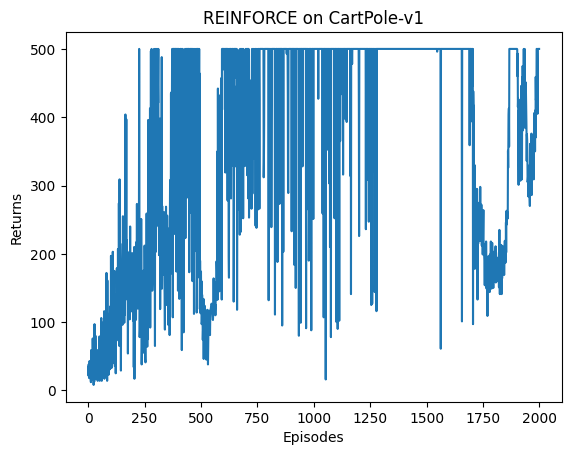

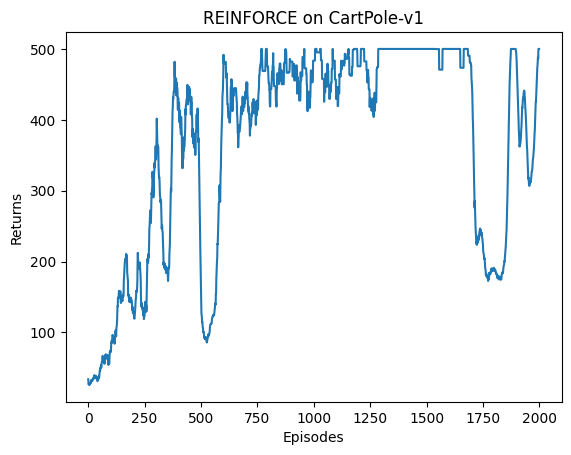

In [29]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 15)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

## Baseline-Reinforce

In [3]:
## 策略网络
## 输入状态，输出选择每个动作的概率
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Softmax())
    def forward(self,x):
        return self.fc2(self.fc1(x))
    
## 价值网络
## 输入状态，输出状态平均的价值
class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,x):
        return self.fc2(self.fc1(x))

In [9]:
class Baseline_Reinforce():
    def __init__(self,state_dim,hidden_dim,action_dim,gamma,lr,device):
        self.policy_net=PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        self.value_net=ValueNet(state_dim,hidden_dim).to(device)
        self.policy_optimizer=optim.Adam(self.policy_net.parameters(),lr=lr)
        self.value_optimizer=optim.Adam(self.value_net.parameters(),lr=lr)
        self.device=device
        self.gamma=gamma
    def take_action(self,state):
        state=torch.FloatTensor(state).unsqueeze(0).to(device)
        prod=self.policy_net(state)
        action_dist=torch.distributions.Categorical(prod)
        action=action_dist.sample()
        return action.item()
    def update(self,trans_dict):
        states=trans_dict['states']
        rewards=trans_dict['rewards']
        actions=trans_dict['actions']
        G=0
        
        for i in reversed(range(len(rewards))):
            reward=rewards[i]
            state=torch.FloatTensor(states[i]).unsqueeze(0).to(self.device)
            action=torch.tensor(np.array([actions[i]])).view(-1,1).to(self.device)
            log_prod=torch.log(self.policy_net(state).gather(1,action))
            v_s=self.value_net(state)
            
            ## 更新策略网络
            self.policy_optimizer.zero_grad()
            G=self.gamma*G+reward
            policy_loss=-(G-v_s).detach()*log_prod
            policy_loss.backward()
            self.policy_optimizer.step()
            
            ## 价值网络用与拟合实际价值G
            ## 用平方误差更新价值网络
            self.value_optimizer.zero_grad()
            value_loss=(G-v_s)**2
            value_loss.backward()
            self.value_optimizer.step()
        
        
        
        

In [12]:
## 学习率不宜过大，否则训练效果不稳定
lr=4e-4
epochs=1000
hidden_dim=64
gamma=0.99
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
env_name='CartPole-v1'
env=gym.make(env_name)
torch.manual_seed(0)
state_dim=env.observation_space.shape[0]
action_dim=env.action_space.n
agent=Baseline_Reinforce(state_dim,hidden_dim,action_dim,gamma,lr,device)

return_list=[]

for i in range(10):
    with tqdm(total=int(epochs/10),desc='iter %d'%i)as pbar:
        for j in range(epochs//10):
            epoch_return=0
            trans_dict={
                'states':[],
                'actions':[],
                'rewards':[],
                'next_states':[],
                'dones':[]
            }
            state,_=env.reset(seed=0)
            done1=False
            done2=False
            while (not done1)and (not done2):
                action=agent.take_action(state)
                next_state,reward,done1,done2,_=env.step(action)
                trans_dict['states'].append(state)
                trans_dict['actions'].append(action)
                trans_dict['rewards'].append(reward)
                trans_dict['next_states'].append(next_state)
                trans_dict['dones'].append(done1)
                state=next_state
                epoch_return+=reward
            return_list.append(epoch_return)
            agent.update(trans_dict)
            
            if (j+1)%10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+j+j),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)
    
                

iter 9: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it, epoch=1098, return=500.000]


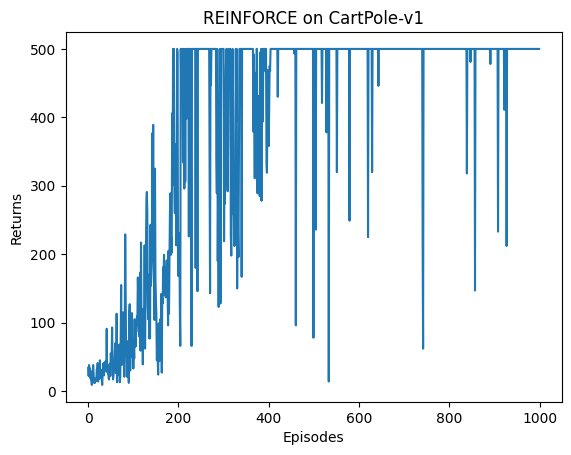

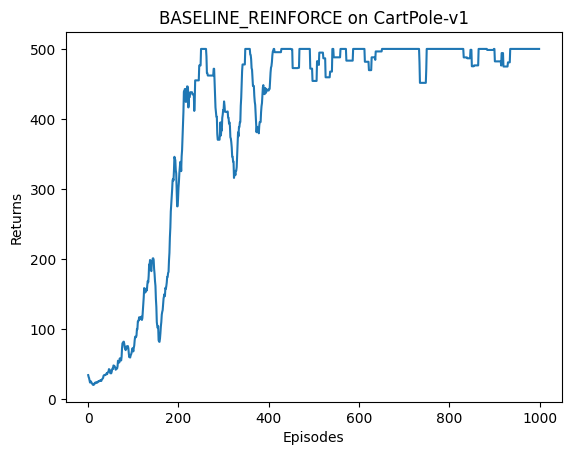

In [18]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 15)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('BASELINE_REINFORCE on {}'.format(env_name))
plt.show()